# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel works with user-defined LFs. Run every cell in the notebook (unless otherwise noted) before proceeding to the next one!
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import tensorflow as tf
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((dev_df, dev_labels), train_df, (test_df, test_labels)) = load_data("data")

**Input Data:** `dev_df` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below. We have other tutorials focused on generating such datasets (e.g., from richy-formatted data), but assume we have access to a Pandas DataFrame for the purpose of this specific tutorial!

In [2]:
dev_df.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, ..."
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton,..."
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue ...","[Prior, to, both, his, guests, ,, Colbert, s, ...","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, s..."
4,"(2, 2)","(4, 5)",People reported Williams and Ven Veen tied the...,"[People, reported, Williams, and, Ven, Veen, t...","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


You'll interact with these candidates while writing labeling functions in Snorkel. We look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = dev_df.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


# Part 2: Writing  Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse classification task below.

A labeling function is a Python function that accepts a candidate, or a row of the DataFrame, as the input argument and outputs a label for the candidate. For ease of exposition in this notebook, we return `1` if it says the pair of persons in the candidate were married at some point,  `-1` if the pair of persons in the candidate were never married, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are often unipolar: it labels only `1`s and `0`s, or it labels only `-1`s and `0`s.

(Note we will change our mapping to use `2` to represent the absence of a relationship to match the multiclass convention when feeding it to the LabelModel later.)
Recall that our goal is to ultimately train a high-performance classification model that predicts which of our candidates are true spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

#  I. Background

## Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

###  Using a _Development Set_ of Human-labeled Data

In our setting, we will use the phrase _development set_ to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions.  Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions. This is a list of `{-1,1}` labels.

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. Note that other domains and tasks, the required preprocessors will be different.

We provide several helper functions in `preprocessors`:  these are Python helper functions that you can apply to candidates in the DataFrame to return objects that are helpful during LF development. You can (and should!) write your own helper functions to help write LFs.

We provide an example of a preprocessor definition here:

In [4]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

## Candidate PreProcessors

We provide a set of helper functions for this task in `preprocessors.py` that take as input a candidate, or row of a DataFrame in our case. For the purpose of the tutorial, we have two of these fields preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_between_tokens(cand)`

`get_left_tokens(cand)`

`get_right_tokens(cand)`

II. Labeling Functions

# A. Pattern Matching Labeling Functions

One powerful form of labeling function design is defining sets of keywords or regular expressions that, as a human labeler, you know are correlated with the true label. For example, we could define a dictionary of terms that occur between person names in a candidate. One simple dictionary of terms indicating a true relation could be, which we could use in a labeling function like shown below:

    spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


    @labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
    def lf_husband_wife_left_window(x, spouses):
        if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
            return POSITIVE
        elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
            return POSITIVE
        else:
            return ABSTAIN

**Note that:**
1. To access the text between the person mentions, we can use the **`get_left_tokens` preprocessor!**
2. We use **resources like the spouses dictionary** to encode themes/categories of relationships!

There are a few advantages of having preprocessors and labeling functions in this form:

**Data Agnostic:**  Operate over multiple data types without rewriting

**Incremental Processing:** Can create preprocessors as needed while writing LFs!

**Future Use:** Can store them for later for different tasks since they are reproducible and modular

**Optimizations:** Allows caching behind-the-scenes

In [5]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = -1
ABSTAIN = 0

In [6]:
# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(preprocessors=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the words `and ... married` between person mentions
@labeling_function()
def lf_and_married(x):
    return (
        POSITIVE
        if "and" in x.between_tokens and "married" in x.person2_right_tokens
        else ABSTAIN
    )

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = [
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
]
family = set(family + [f + "-in-law" for f in family])


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), preprocessors=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [12]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_and_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
]
applier = PandasLFApplier(lfs)
L = applier.apply(dev_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  2%|▏         | 65/2811 [00:00<00:04, 643.42it/s]

  5%|▍         | 131/2811 [00:00<00:04, 646.74it/s]

  7%|▋         | 195/2811 [00:00<00:04, 644.45it/s]

  9%|▉         | 259/2811 [00:00<00:03, 641.43it/s]

 12%|█▏        | 324/2811 [00:00<00:03, 642.38it/s]

 14%|█▍        | 387/2811 [00:00<00:03, 637.22it/s]

 16%|█▌        | 452/2811 [00:00<00:03, 639.11it/s]

 18%|█▊        | 518/2811 [00:00<00:03, 642.52it/s]

 21%|██        | 583/2811 [00:00<00:03, 643.67it/s]

 23%|██▎       | 649/2811 [00:01<00:03, 647.33it/s]

 25%|██▌       | 714/2811 [00:01<00:03, 647.42it/s]

 28%|██▊       | 780/2811 [00:01<00:03, 649.73it/s]

 30%|███       | 845/2811 [00:01<00:03, 647.46it/s]

 32%|███▏      | 910/2811 [00:01<00:02, 647.71it/s]

 35%|███▍      | 976/2811 [00:01<00:02, 648.91it/s]

 37%|███▋      | 1041/2811 [00:01<00:02, 645.62it/s]

 39%|███▉      | 1106/2811 [00:01<00:02, 644.39it/s]

 42%|████▏     | 1171/2811 [00:01<00:02, 645.63it/s]

 44%|████▍     | 1236/2811 [00:01<00:02, 644.97it/s]

 46%|████▋     | 1301/2811 [00:02<00:02, 645.44it/s]

 49%|████▊     | 1367/2811 [00:02<00:02, 648.60it/s]

 51%|█████     | 1432/2811 [00:02<00:02, 648.14it/s]

 53%|█████▎    | 1497/2811 [00:02<00:02, 647.90it/s]

 56%|█████▌    | 1563/2811 [00:02<00:01, 649.04it/s]

 58%|█████▊    | 1628/2811 [00:02<00:01, 646.44it/s]

 60%|██████    | 1693/2811 [00:02<00:01, 646.98it/s]

 63%|██████▎   | 1758/2811 [00:02<00:01, 645.83it/s]

 65%|██████▍   | 1823/2811 [00:02<00:01, 642.72it/s]

 67%|██████▋   | 1889/2811 [00:02<00:01, 645.35it/s]

 70%|██████▉   | 1955/2811 [00:03<00:01, 647.70it/s]

 72%|███████▏  | 2020/2811 [00:03<00:01, 643.89it/s]

 74%|███████▍  | 2085/2811 [00:03<00:01, 641.23it/s]

 76%|███████▋  | 2150/2811 [00:03<00:01, 642.54it/s]

 79%|███████▉  | 2215/2811 [00:03<00:00, 643.85it/s]

 81%|████████  | 2281/2811 [00:03<00:00, 645.97it/s]

 83%|████████▎ | 2346/2811 [00:03<00:00, 646.25it/s]

 86%|████████▌ | 2412/2811 [00:03<00:00, 647.67it/s]

 88%|████████▊ | 2477/2811 [00:03<00:00, 648.01it/s]

 90%|█████████ | 2543/2811 [00:03<00:00, 649.22it/s]

 93%|█████████▎| 2609/2811 [00:04<00:00, 649.73it/s]

 95%|█████████▌| 2674/2811 [00:04<00:00, 649.80it/s]

 97%|█████████▋| 2739/2811 [00:04<00:00, 648.41it/s]

100%|█████████▉| 2804/2811 [00:04<00:00, 648.36it/s]

100%|██████████| 2811/2811 [00:04<00:00, 645.72it/s]

### Labeling Function Metrics

We can use the lf_summary function to measure various coverage related metrics for LFs. If we have gold labeled data, we can also evaluate accuracy.

#### Polarity
The set of label values the LF can output when it doesn't abstain. It is common for each LF to have a single polarity.

#### Coverage
The fraction of candidates that is labeled by our LF.

#### Overlaps
The fraction of examples labeled by the LF that is also labeled by another LF.

#### Conflicts
The fraction of examples labeled by the LF that is given a different (non-abstain) label by another LF.

#### Correct
The number of correctly labeled examples on the gold labeled data.

#### Incorrect
The number of incorrectly labeled examples on the gold labeled data.

#### Empirical Accuracy
The fraction of correctly labeled examples on the gold data.

In [13]:
from snorkel.analysis.utils import convert_labels
from snorkel.labeling.analysis import lf_summary
from scipy.sparse import csr_matrix

Y_cat = convert_labels(dev_labels, "plusminus", "categorical")
L_cat = convert_labels(L.todense(), "plusminus", "categorical")
lf_names = [lf.name for lf in lfs]

lf_summary(csr_matrix(L_cat), Y_cat, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.035930,0.017432,93,146,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.020633,0.003557,30,39,0.422535
lf_same_last_name,2,[1],0.040555,0.014941,0.008538,19,95,0.166667
lf_and_married,3,[1],0.001423,0.000000,0.000000,2,2,0.500000
lf_familial_relationship,4,[2],0.115617,0.049449,0.023835,299,15,0.920000
lf_family_left_window,5,[2],0.041266,0.033440,0.007826,110,2,0.948276
lf_other_relationship,6,[2],0.013874,0.002846,0.002846,30,6,0.769231


## B. Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [14]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('Jere Burns', 'Kathleen Kinmont'),
 ('Tamzin Maria Outhwaite', 'Tom Ellis'),
 ('Marie Wilson', 'Nick Grinde'),
 ('Eleonore Marie of Anhalt-Bernburg', 'John Albert II Duke of Mecklenburg'),
 ('Jeanne St. Laurent', 'Louis Stephen St-Laurent')]

In [15]:
@labeling_function(
    resources=dict(known_spouses=known_spouses), preprocessors=[get_person_text]
)
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    return (
        POSITIVE if (p1, p2) in known_spouses or (p2, p1) in known_spouses else ABSTAIN
    )

In [16]:
# Helper function to get last name for dbpedia entries.
def last_name(s):
    name_parts = s.split(" ")
    return name_parts[-1] if len(name_parts) > 1 else None


# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(
    resources=dict(last_names=last_names), preprocessors=[get_person_last_names]
)
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

Every time you write a new labeling function, add it to appliers and make sure to include it in the new L matrix!

In [17]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_and_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [18]:
dev_L = applier.apply(dev_df)

train_L = applier.apply(train_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 39/2811 [00:00<00:07, 383.83it/s]

  3%|▎         | 78/2811 [00:00<00:07, 383.57it/s]

  4%|▍         | 117/2811 [00:00<00:07, 383.84it/s]

  6%|▌         | 156/2811 [00:00<00:06, 383.28it/s]

  7%|▋         | 194/2811 [00:00<00:06, 381.60it/s]

  8%|▊         | 232/2811 [00:00<00:06, 380.32it/s]

 10%|▉         | 271/2811 [00:00<00:06, 380.59it/s]

 11%|█         | 310/2811 [00:00<00:06, 381.91it/s]

 12%|█▏        | 348/2811 [00:00<00:06, 378.68it/s]

 14%|█▎        | 386/2811 [00:01<00:06, 378.67it/s]

 15%|█▌        | 424/2811 [00:01<00:06, 377.44it/s]

 16%|█▋        | 463/2811 [00:01<00:06, 379.46it/s]

 18%|█▊        | 502/2811 [00:01<00:06, 380.94it/s]

 19%|█▉        | 541/2811 [00:01<00:05, 381.16it/s]

 21%|██        | 580/2811 [00:01<00:05, 382.44it/s]

 22%|██▏       | 619/2811 [00:01<00:05, 384.67it/s]

 23%|██▎       | 658/2811 [00:01<00:05, 384.46it/s]

 25%|██▍       | 697/2811 [00:01<00:05, 383.68it/s]

 26%|██▌       | 736/2811 [00:01<00:05, 384.67it/s]

 28%|██▊       | 775/2811 [00:02<00:05, 385.46it/s]

 29%|██▉       | 814/2811 [00:02<00:05, 383.85it/s]

 30%|███       | 853/2811 [00:02<00:05, 381.85it/s]

 32%|███▏      | 892/2811 [00:02<00:05, 382.47it/s]

 33%|███▎      | 931/2811 [00:02<00:04, 382.85it/s]

 35%|███▍      | 970/2811 [00:02<00:04, 384.20it/s]

 36%|███▌      | 1009/2811 [00:02<00:04, 381.50it/s]

 37%|███▋      | 1048/2811 [00:02<00:04, 381.29it/s]

 39%|███▊      | 1087/2811 [00:02<00:04, 380.73it/s]

 40%|████      | 1126/2811 [00:02<00:04, 381.75it/s]

 41%|████▏     | 1165/2811 [00:03<00:04, 382.64it/s]

 43%|████▎     | 1204/2811 [00:03<00:04, 383.15it/s]

 44%|████▍     | 1243/2811 [00:03<00:04, 383.07it/s]

 46%|████▌     | 1282/2811 [00:03<00:03, 384.13it/s]

 47%|████▋     | 1321/2811 [00:03<00:03, 385.25it/s]

 48%|████▊     | 1361/2811 [00:03<00:03, 386.78it/s]

 50%|████▉     | 1400/2811 [00:03<00:03, 387.44it/s]

 51%|█████     | 1439/2811 [00:03<00:03, 386.24it/s]

 53%|█████▎    | 1478/2811 [00:03<00:03, 386.72it/s]

 54%|█████▍    | 1517/2811 [00:03<00:03, 385.80it/s]

 55%|█████▌    | 1556/2811 [00:04<00:03, 386.06it/s]

 57%|█████▋    | 1595/2811 [00:04<00:03, 385.76it/s]

 58%|█████▊    | 1634/2811 [00:04<00:03, 384.43it/s]

 60%|█████▉    | 1673/2811 [00:04<00:02, 385.49it/s]

 61%|██████    | 1712/2811 [00:04<00:02, 384.33it/s]

 62%|██████▏   | 1751/2811 [00:04<00:02, 385.23it/s]

 64%|██████▎   | 1790/2811 [00:04<00:02, 383.66it/s]

 65%|██████▌   | 1829/2811 [00:04<00:02, 382.50it/s]

 66%|██████▋   | 1868/2811 [00:04<00:02, 384.42it/s]

 68%|██████▊   | 1907/2811 [00:04<00:02, 385.33it/s]

 69%|██████▉   | 1946/2811 [00:05<00:02, 386.67it/s]

 71%|███████   | 1985/2811 [00:05<00:02, 386.53it/s]

 72%|███████▏  | 2024/2811 [00:05<00:02, 382.81it/s]

 73%|███████▎  | 2063/2811 [00:05<00:01, 380.00it/s]

 75%|███████▍  | 2102/2811 [00:05<00:01, 380.73it/s]

 76%|███████▌  | 2141/2811 [00:05<00:01, 381.87it/s]

 78%|███████▊  | 2180/2811 [00:05<00:01, 381.86it/s]

 79%|███████▉  | 2219/2811 [00:05<00:01, 382.78it/s]

 80%|████████  | 2258/2811 [00:05<00:01, 383.91it/s]

 82%|████████▏ | 2297/2811 [00:05<00:01, 383.02it/s]

 83%|████████▎ | 2336/2811 [00:06<00:01, 383.73it/s]

 84%|████████▍ | 2375/2811 [00:06<00:01, 384.56it/s]

 86%|████████▌ | 2414/2811 [00:06<00:01, 384.80it/s]

 87%|████████▋ | 2453/2811 [00:06<00:00, 384.73it/s]

 89%|████████▊ | 2492/2811 [00:06<00:00, 385.31it/s]

 90%|█████████ | 2531/2811 [00:06<00:00, 385.21it/s]

 91%|█████████▏| 2570/2811 [00:06<00:00, 385.39it/s]

 93%|█████████▎| 2609/2811 [00:06<00:00, 385.57it/s]

 94%|█████████▍| 2648/2811 [00:06<00:00, 386.06it/s]

 96%|█████████▌| 2687/2811 [00:07<00:00, 385.08it/s]

 97%|█████████▋| 2726/2811 [00:07<00:00, 384.86it/s]

 98%|█████████▊| 2765/2811 [00:07<00:00, 385.22it/s]

100%|█████████▉| 2804/2811 [00:07<00:00, 384.96it/s]

100%|██████████| 2811/2811 [00:07<00:00, 383.39it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 37/22254 [00:00<01:01, 362.47it/s]

  0%|          | 75/22254 [00:00<01:00, 366.89it/s]

  1%|          | 113/22254 [00:00<00:59, 370.27it/s]

  1%|          | 151/22254 [00:00<00:59, 371.37it/s]

  1%|          | 189/22254 [00:00<00:59, 373.67it/s]

  1%|          | 228/22254 [00:00<00:58, 376.09it/s]

  1%|          | 267/22254 [00:00<00:58, 378.44it/s]

  1%|▏         | 306/22254 [00:00<00:57, 379.34it/s]

  2%|▏         | 344/22254 [00:00<00:57, 379.26it/s]

  2%|▏         | 382/22254 [00:01<00:58, 376.80it/s]

  2%|▏         | 420/22254 [00:01<00:57, 377.62it/s]

  2%|▏         | 459/22254 [00:01<00:57, 379.21it/s]

  2%|▏         | 497/22254 [00:01<00:57, 379.14it/s]

  2%|▏         | 535/22254 [00:01<00:57, 375.07it/s]

  3%|▎         | 573/22254 [00:01<00:57, 375.54it/s]

  3%|▎         | 612/22254 [00:01<00:57, 377.82it/s]

  3%|▎         | 650/22254 [00:01<00:57, 377.02it/s]

  3%|▎         | 688/22254 [00:01<00:57, 377.76it/s]

  3%|▎         | 727/22254 [00:01<00:56, 379.34it/s]

  3%|▎         | 766/22254 [00:02<00:56, 380.52it/s]

  4%|▎         | 805/22254 [00:02<00:56, 380.75it/s]

  4%|▍         | 844/22254 [00:02<00:56, 381.13it/s]

  4%|▍         | 883/22254 [00:02<00:56, 380.52it/s]

  4%|▍         | 922/22254 [00:02<00:55, 381.76it/s]

  4%|▍         | 961/22254 [00:02<00:55, 382.53it/s]

  4%|▍         | 1000/22254 [00:02<00:55, 382.09it/s]

  5%|▍         | 1039/22254 [00:02<00:55, 381.59it/s]

  5%|▍         | 1078/22254 [00:02<00:55, 380.96it/s]

  5%|▌         | 1117/22254 [00:02<00:55, 380.08it/s]

  5%|▌         | 1156/22254 [00:03<00:55, 381.03it/s]

  5%|▌         | 1195/22254 [00:03<00:55, 381.56it/s]

  6%|▌         | 1234/22254 [00:03<00:55, 380.87it/s]

  6%|▌         | 1273/22254 [00:03<00:54, 381.92it/s]

  6%|▌         | 1312/22254 [00:03<00:54, 383.08it/s]

  6%|▌         | 1351/22254 [00:03<00:54, 382.90it/s]

  6%|▌         | 1390/22254 [00:03<00:54, 382.81it/s]

  6%|▋         | 1429/22254 [00:03<00:55, 377.39it/s]

  7%|▋         | 1467/22254 [00:03<00:55, 377.32it/s]

  7%|▋         | 1506/22254 [00:03<00:54, 379.03it/s]

  7%|▋         | 1545/22254 [00:04<00:54, 379.63it/s]

  7%|▋         | 1583/22254 [00:04<00:54, 377.58it/s]

  7%|▋         | 1622/22254 [00:04<00:54, 379.11it/s]

  7%|▋         | 1660/22254 [00:04<00:54, 379.27it/s]

  8%|▊         | 1698/22254 [00:04<00:54, 378.76it/s]

  8%|▊         | 1736/22254 [00:04<00:54, 378.24it/s]

  8%|▊         | 1774/22254 [00:04<00:54, 378.22it/s]

  8%|▊         | 1813/22254 [00:04<00:53, 379.96it/s]

  8%|▊         | 1852/22254 [00:04<00:53, 381.45it/s]

  8%|▊         | 1891/22254 [00:04<00:53, 380.17it/s]

  9%|▊         | 1930/22254 [00:05<00:54, 371.65it/s]

  9%|▉         | 1969/22254 [00:05<00:54, 374.39it/s]

  9%|▉         | 2007/22254 [00:05<00:53, 375.88it/s]

  9%|▉         | 2045/22254 [00:05<00:53, 376.96it/s]

  9%|▉         | 2084/22254 [00:05<00:53, 377.97it/s]

 10%|▉         | 2122/22254 [00:05<00:53, 377.20it/s]

 10%|▉         | 2160/22254 [00:05<00:53, 376.96it/s]

 10%|▉         | 2198/22254 [00:05<00:53, 376.34it/s]

 10%|█         | 2237/22254 [00:05<00:52, 378.08it/s]

 10%|█         | 2276/22254 [00:06<00:52, 380.54it/s]

 10%|█         | 2315/22254 [00:06<00:52, 380.58it/s]

 11%|█         | 2354/22254 [00:06<00:52, 379.80it/s]

 11%|█         | 2392/22254 [00:06<00:52, 379.39it/s]

 11%|█         | 2430/22254 [00:06<00:52, 376.97it/s]

 11%|█         | 2468/22254 [00:06<00:52, 377.81it/s]

 11%|█▏        | 2507/22254 [00:06<00:52, 378.92it/s]

 11%|█▏        | 2545/22254 [00:06<00:52, 377.11it/s]

 12%|█▏        | 2583/22254 [00:06<00:52, 377.59it/s]

 12%|█▏        | 2621/22254 [00:06<00:51, 378.10it/s]

 12%|█▏        | 2659/22254 [00:07<00:52, 374.58it/s]

 12%|█▏        | 2697/22254 [00:07<00:52, 374.62it/s]

 12%|█▏        | 2736/22254 [00:07<00:51, 376.70it/s]

 12%|█▏        | 2774/22254 [00:07<00:51, 376.48it/s]

 13%|█▎        | 2812/22254 [00:07<00:51, 377.43it/s]

 13%|█▎        | 2850/22254 [00:07<00:51, 375.90it/s]

 13%|█▎        | 2888/22254 [00:07<00:51, 376.89it/s]

 13%|█▎        | 2926/22254 [00:07<00:51, 377.82it/s]

 13%|█▎        | 2965/22254 [00:07<00:50, 379.75it/s]

 13%|█▎        | 3004/22254 [00:07<00:50, 380.40it/s]

 14%|█▎        | 3043/22254 [00:08<00:50, 379.50it/s]

 14%|█▍        | 3082/22254 [00:08<00:50, 380.01it/s]

 14%|█▍        | 3121/22254 [00:08<00:50, 380.79it/s]

 14%|█▍        | 3160/22254 [00:08<00:50, 379.52it/s]

 14%|█▍        | 3198/22254 [00:08<00:50, 378.28it/s]

 15%|█▍        | 3237/22254 [00:08<00:50, 379.64it/s]

 15%|█▍        | 3276/22254 [00:08<00:49, 381.15it/s]

 15%|█▍        | 3315/22254 [00:08<00:49, 381.32it/s]

 15%|█▌        | 3354/22254 [00:08<00:49, 381.10it/s]

 15%|█▌        | 3393/22254 [00:08<00:49, 380.57it/s]

 15%|█▌        | 3432/22254 [00:09<00:49, 380.13it/s]

 16%|█▌        | 3471/22254 [00:09<00:49, 379.15it/s]

 16%|█▌        | 3509/22254 [00:09<00:49, 378.85it/s]

 16%|█▌        | 3547/22254 [00:09<00:49, 377.41it/s]

 16%|█▌        | 3585/22254 [00:09<00:49, 376.18it/s]

 16%|█▋        | 3623/22254 [00:09<00:50, 370.81it/s]

 16%|█▋        | 3661/22254 [00:09<00:49, 372.96it/s]

 17%|█▋        | 3700/22254 [00:09<00:49, 375.84it/s]

 17%|█▋        | 3738/22254 [00:09<00:49, 376.75it/s]

 17%|█▋        | 3776/22254 [00:09<00:48, 377.47it/s]

 17%|█▋        | 3814/22254 [00:10<00:49, 376.21it/s]

 17%|█▋        | 3853/22254 [00:10<00:48, 377.63it/s]

 17%|█▋        | 3891/22254 [00:10<00:48, 378.32it/s]

 18%|█▊        | 3930/22254 [00:10<00:48, 379.55it/s]

 18%|█▊        | 3969/22254 [00:10<00:48, 380.03it/s]

 18%|█▊        | 4008/22254 [00:10<00:48, 379.13it/s]

 18%|█▊        | 4046/22254 [00:10<00:48, 377.15it/s]

 18%|█▊        | 4085/22254 [00:10<00:47, 378.58it/s]

 19%|█▊        | 4123/22254 [00:10<00:47, 378.56it/s]

 19%|█▊        | 4161/22254 [00:10<00:47, 377.47it/s]

 19%|█▉        | 4199/22254 [00:11<00:47, 377.19it/s]

 19%|█▉        | 4237/22254 [00:11<00:47, 376.76it/s]

 19%|█▉        | 4275/22254 [00:11<00:47, 376.88it/s]

 19%|█▉        | 4313/22254 [00:11<00:47, 377.32it/s]

 20%|█▉        | 4351/22254 [00:11<00:47, 377.04it/s]

 20%|█▉        | 4389/22254 [00:11<00:47, 377.07it/s]

 20%|█▉        | 4427/22254 [00:11<00:47, 376.05it/s]

 20%|██        | 4465/22254 [00:11<00:47, 376.68it/s]

 20%|██        | 4503/22254 [00:11<00:47, 377.26it/s]

 20%|██        | 4542/22254 [00:12<00:46, 379.48it/s]

 21%|██        | 4580/22254 [00:12<00:46, 378.80it/s]

 21%|██        | 4619/22254 [00:12<00:46, 379.74it/s]

 21%|██        | 4657/22254 [00:12<00:46, 379.78it/s]

 21%|██        | 4695/22254 [00:12<00:46, 378.41it/s]

 21%|██▏       | 4733/22254 [00:12<00:46, 377.45it/s]

 21%|██▏       | 4771/22254 [00:12<00:46, 378.08it/s]

 22%|██▏       | 4809/22254 [00:12<00:46, 378.24it/s]

 22%|██▏       | 4848/22254 [00:12<00:45, 379.18it/s]

 22%|██▏       | 4886/22254 [00:12<00:46, 377.28it/s]

 22%|██▏       | 4924/22254 [00:13<00:45, 377.34it/s]

 22%|██▏       | 4962/22254 [00:13<00:45, 377.93it/s]

 22%|██▏       | 5001/22254 [00:13<00:45, 378.94it/s]

 23%|██▎       | 5040/22254 [00:13<00:45, 379.61it/s]

 23%|██▎       | 5078/22254 [00:13<00:45, 377.08it/s]

 23%|██▎       | 5117/22254 [00:13<00:45, 378.01it/s]

 23%|██▎       | 5155/22254 [00:13<00:45, 378.01it/s]

 23%|██▎       | 5193/22254 [00:13<00:45, 377.15it/s]

 24%|██▎       | 5231/22254 [00:13<00:45, 377.92it/s]

 24%|██▎       | 5269/22254 [00:13<00:44, 377.85it/s]

 24%|██▍       | 5307/22254 [00:14<00:44, 378.22it/s]

 24%|██▍       | 5346/22254 [00:14<00:44, 378.95it/s]

 24%|██▍       | 5384/22254 [00:14<00:44, 378.24it/s]

 24%|██▍       | 5422/22254 [00:14<00:44, 378.06it/s]

 25%|██▍       | 5460/22254 [00:14<00:44, 378.37it/s]

 25%|██▍       | 5499/22254 [00:14<00:44, 379.22it/s]

 25%|██▍       | 5538/22254 [00:14<00:43, 380.77it/s]

 25%|██▌       | 5577/22254 [00:14<00:43, 380.41it/s]

 25%|██▌       | 5616/22254 [00:14<00:43, 379.78it/s]

 25%|██▌       | 5655/22254 [00:14<00:43, 379.88it/s]

 26%|██▌       | 5694/22254 [00:15<00:43, 380.20it/s]

 26%|██▌       | 5733/22254 [00:15<00:43, 380.70it/s]

 26%|██▌       | 5772/22254 [00:15<00:43, 380.74it/s]

 26%|██▌       | 5811/22254 [00:15<00:43, 381.90it/s]

 26%|██▋       | 5850/22254 [00:15<00:42, 382.33it/s]

 26%|██▋       | 5889/22254 [00:15<00:42, 382.58it/s]

 27%|██▋       | 5928/22254 [00:15<00:43, 379.42it/s]

 27%|██▋       | 5967/22254 [00:15<00:42, 380.42it/s]

 27%|██▋       | 6006/22254 [00:15<00:42, 379.92it/s]

 27%|██▋       | 6044/22254 [00:15<00:42, 379.77it/s]

 27%|██▋       | 6082/22254 [00:16<00:42, 379.19it/s]

 28%|██▊       | 6120/22254 [00:16<00:42, 378.26it/s]

 28%|██▊       | 6158/22254 [00:16<00:42, 377.49it/s]

 28%|██▊       | 6196/22254 [00:16<00:42, 376.00it/s]

 28%|██▊       | 6234/22254 [00:16<00:42, 375.16it/s]

 28%|██▊       | 6273/22254 [00:16<00:42, 377.03it/s]

 28%|██▊       | 6312/22254 [00:16<00:42, 378.72it/s]

 29%|██▊       | 6351/22254 [00:16<00:41, 380.00it/s]

 29%|██▊       | 6390/22254 [00:16<00:41, 379.87it/s]

 29%|██▉       | 6429/22254 [00:16<00:41, 380.42it/s]

 29%|██▉       | 6468/22254 [00:17<00:41, 380.79it/s]

 29%|██▉       | 6507/22254 [00:17<00:41, 379.82it/s]

 29%|██▉       | 6546/22254 [00:17<00:41, 380.11it/s]

 30%|██▉       | 6585/22254 [00:17<00:41, 380.38it/s]

 30%|██▉       | 6624/22254 [00:17<00:41, 380.58it/s]

 30%|██▉       | 6663/22254 [00:17<00:41, 379.06it/s]

 30%|███       | 6702/22254 [00:17<00:41, 379.31it/s]

 30%|███       | 6741/22254 [00:17<00:40, 379.63it/s]

 30%|███       | 6779/22254 [00:17<00:40, 379.55it/s]

 31%|███       | 6818/22254 [00:18<00:40, 380.07it/s]

 31%|███       | 6857/22254 [00:18<00:40, 379.89it/s]

 31%|███       | 6896/22254 [00:18<00:40, 380.51it/s]

 31%|███       | 6935/22254 [00:18<00:40, 380.23it/s]

 31%|███▏      | 6974/22254 [00:18<00:40, 378.29it/s]

 32%|███▏      | 7012/22254 [00:18<00:40, 374.71it/s]

 32%|███▏      | 7051/22254 [00:18<00:40, 377.80it/s]

 32%|███▏      | 7090/22254 [00:18<00:40, 378.67it/s]

 32%|███▏      | 7128/22254 [00:18<00:39, 379.01it/s]

 32%|███▏      | 7167/22254 [00:18<00:39, 380.50it/s]

 32%|███▏      | 7206/22254 [00:19<00:39, 379.59it/s]

 33%|███▎      | 7245/22254 [00:19<00:39, 380.08it/s]

 33%|███▎      | 7284/22254 [00:19<00:39, 379.83it/s]

 33%|███▎      | 7323/22254 [00:19<00:39, 380.44it/s]

 33%|███▎      | 7362/22254 [00:19<00:39, 380.00it/s]

 33%|███▎      | 7401/22254 [00:19<00:38, 381.42it/s]

 33%|███▎      | 7440/22254 [00:19<00:38, 381.50it/s]

 34%|███▎      | 7479/22254 [00:19<00:39, 377.24it/s]

 34%|███▍      | 7518/22254 [00:19<00:38, 380.11it/s]

 34%|███▍      | 7557/22254 [00:19<00:38, 379.99it/s]

 34%|███▍      | 7596/22254 [00:20<00:38, 380.49it/s]

 34%|███▍      | 7635/22254 [00:20<00:38, 381.57it/s]

 34%|███▍      | 7674/22254 [00:20<00:38, 381.27it/s]

 35%|███▍      | 7713/22254 [00:20<00:38, 381.63it/s]

 35%|███▍      | 7752/22254 [00:20<00:38, 380.92it/s]

 35%|███▌      | 7791/22254 [00:20<00:37, 380.90it/s]

 35%|███▌      | 7830/22254 [00:20<00:37, 379.69it/s]

 35%|███▌      | 7868/22254 [00:20<00:37, 379.65it/s]

 36%|███▌      | 7907/22254 [00:20<00:37, 379.91it/s]

 36%|███▌      | 7945/22254 [00:20<00:37, 377.15it/s]

 36%|███▌      | 7983/22254 [00:21<00:38, 374.25it/s]

 36%|███▌      | 8021/22254 [00:21<00:37, 374.83it/s]

 36%|███▌      | 8059/22254 [00:21<00:37, 375.13it/s]

 36%|███▋      | 8098/22254 [00:21<00:37, 377.45it/s]

 37%|███▋      | 8136/22254 [00:21<00:37, 377.89it/s]

 37%|███▋      | 8174/22254 [00:21<00:37, 377.18it/s]

 37%|███▋      | 8212/22254 [00:21<00:37, 377.17it/s]

 37%|███▋      | 8251/22254 [00:21<00:36, 380.10it/s]

 37%|███▋      | 8290/22254 [00:21<00:36, 381.48it/s]

 37%|███▋      | 8329/22254 [00:21<00:36, 381.37it/s]

 38%|███▊      | 8368/22254 [00:22<00:36, 379.78it/s]

 38%|███▊      | 8407/22254 [00:22<00:36, 380.08it/s]

 38%|███▊      | 8446/22254 [00:22<00:36, 381.14it/s]

 38%|███▊      | 8485/22254 [00:22<00:36, 381.90it/s]

 38%|███▊      | 8524/22254 [00:22<00:36, 380.74it/s]

 38%|███▊      | 8563/22254 [00:22<00:35, 382.20it/s]

 39%|███▊      | 8602/22254 [00:22<00:35, 381.72it/s]

 39%|███▉      | 8641/22254 [00:22<00:35, 381.72it/s]

 39%|███▉      | 8680/22254 [00:22<00:35, 380.90it/s]

 39%|███▉      | 8719/22254 [00:23<00:35, 379.38it/s]

 39%|███▉      | 8758/22254 [00:23<00:35, 380.16it/s]

 40%|███▉      | 8797/22254 [00:23<00:35, 381.44it/s]

 40%|███▉      | 8836/22254 [00:23<00:35, 382.33it/s]

 40%|███▉      | 8875/22254 [00:23<00:35, 380.99it/s]

 40%|████      | 8914/22254 [00:23<00:35, 377.70it/s]

 40%|████      | 8952/22254 [00:23<00:35, 376.83it/s]

 40%|████      | 8990/22254 [00:23<00:35, 374.45it/s]

 41%|████      | 9028/22254 [00:23<00:35, 375.68it/s]

 41%|████      | 9066/22254 [00:23<00:35, 376.72it/s]

 41%|████      | 9105/22254 [00:24<00:34, 377.97it/s]

 41%|████      | 9143/22254 [00:24<00:34, 375.67it/s]

 41%|████▏     | 9181/22254 [00:24<00:34, 374.34it/s]

 41%|████▏     | 9219/22254 [00:24<00:34, 374.09it/s]

 42%|████▏     | 9257/22254 [00:24<00:34, 372.93it/s]

 42%|████▏     | 9296/22254 [00:24<00:34, 375.82it/s]

 42%|████▏     | 9335/22254 [00:24<00:34, 378.40it/s]

 42%|████▏     | 9374/22254 [00:24<00:33, 380.41it/s]

 42%|████▏     | 9413/22254 [00:24<00:33, 380.52it/s]

 42%|████▏     | 9452/22254 [00:24<00:33, 379.27it/s]

 43%|████▎     | 9490/22254 [00:25<00:33, 379.35it/s]

 43%|████▎     | 9529/22254 [00:25<00:33, 380.20it/s]

 43%|████▎     | 9568/22254 [00:25<00:33, 379.06it/s]

 43%|████▎     | 9607/22254 [00:25<00:33, 380.25it/s]

 43%|████▎     | 9646/22254 [00:25<00:33, 380.94it/s]

 44%|████▎     | 9685/22254 [00:25<00:32, 381.35it/s]

 44%|████▎     | 9724/22254 [00:25<00:32, 381.12it/s]

 44%|████▍     | 9763/22254 [00:25<00:32, 381.84it/s]

 44%|████▍     | 9802/22254 [00:25<00:32, 381.06it/s]

 44%|████▍     | 9841/22254 [00:25<00:32, 381.31it/s]

 44%|████▍     | 9880/22254 [00:26<00:32, 381.90it/s]

 45%|████▍     | 9919/22254 [00:26<00:32, 382.02it/s]

 45%|████▍     | 9958/22254 [00:26<00:32, 381.42it/s]

 45%|████▍     | 9997/22254 [00:26<00:32, 381.70it/s]

 45%|████▌     | 10036/22254 [00:26<00:31, 381.88it/s]

 45%|████▌     | 10075/22254 [00:26<00:31, 382.61it/s]

 45%|████▌     | 10114/22254 [00:26<00:31, 381.53it/s]

 46%|████▌     | 10153/22254 [00:26<00:31, 382.13it/s]

 46%|████▌     | 10192/22254 [00:26<00:31, 382.63it/s]

 46%|████▌     | 10231/22254 [00:26<00:31, 382.78it/s]

 46%|████▌     | 10270/22254 [00:27<00:31, 383.15it/s]

 46%|████▋     | 10309/22254 [00:27<00:31, 382.68it/s]

 46%|████▋     | 10348/22254 [00:27<00:31, 380.48it/s]

 47%|████▋     | 10387/22254 [00:27<00:31, 379.05it/s]

 47%|████▋     | 10425/22254 [00:27<00:31, 379.30it/s]

 47%|████▋     | 10464/22254 [00:27<00:31, 380.19it/s]

 47%|████▋     | 10503/22254 [00:27<00:30, 380.96it/s]

 47%|████▋     | 10542/22254 [00:27<00:30, 382.00it/s]

 48%|████▊     | 10581/22254 [00:27<00:30, 381.92it/s]

 48%|████▊     | 10620/22254 [00:28<00:30, 379.27it/s]

 48%|████▊     | 10658/22254 [00:28<00:30, 378.85it/s]

 48%|████▊     | 10696/22254 [00:28<00:30, 378.77it/s]

 48%|████▊     | 10734/22254 [00:28<00:30, 376.92it/s]

 48%|████▊     | 10772/22254 [00:28<00:30, 376.88it/s]

 49%|████▊     | 10810/22254 [00:28<00:30, 374.90it/s]

 49%|████▉     | 10849/22254 [00:28<00:30, 377.06it/s]

 49%|████▉     | 10888/22254 [00:28<00:30, 378.00it/s]

 49%|████▉     | 10926/22254 [00:28<00:29, 377.91it/s]

 49%|████▉     | 10964/22254 [00:28<00:29, 377.28it/s]

 49%|████▉     | 11003/22254 [00:29<00:29, 378.71it/s]

 50%|████▉     | 11042/22254 [00:29<00:29, 379.95it/s]

 50%|████▉     | 11081/22254 [00:29<00:29, 382.56it/s]

 50%|████▉     | 11120/22254 [00:29<00:29, 382.01it/s]

 50%|█████     | 11159/22254 [00:29<00:29, 381.30it/s]

 50%|█████     | 11198/22254 [00:29<00:28, 381.82it/s]

 50%|█████     | 11237/22254 [00:29<00:28, 380.34it/s]

 51%|█████     | 11276/22254 [00:29<00:28, 380.65it/s]

 51%|█████     | 11315/22254 [00:29<00:28, 380.44it/s]

 51%|█████     | 11354/22254 [00:29<00:28, 377.77it/s]

 51%|█████     | 11393/22254 [00:30<00:28, 379.11it/s]

 51%|█████▏    | 11431/22254 [00:30<00:28, 377.07it/s]

 52%|█████▏    | 11470/22254 [00:30<00:28, 378.65it/s]

 52%|█████▏    | 11508/22254 [00:30<00:28, 378.61it/s]

 52%|█████▏    | 11546/22254 [00:30<00:28, 374.10it/s]

 52%|█████▏    | 11585/22254 [00:30<00:28, 375.99it/s]

 52%|█████▏    | 11623/22254 [00:30<00:28, 376.54it/s]

 52%|█████▏    | 11662/22254 [00:30<00:28, 377.67it/s]

 53%|█████▎    | 11701/22254 [00:30<00:27, 378.56it/s]

 53%|█████▎    | 11740/22254 [00:30<00:27, 379.65it/s]

 53%|█████▎    | 11779/22254 [00:31<00:27, 380.79it/s]

 53%|█████▎    | 11818/22254 [00:31<00:27, 381.08it/s]

 53%|█████▎    | 11857/22254 [00:31<00:27, 380.54it/s]

 53%|█████▎    | 11896/22254 [00:31<00:27, 381.31it/s]

 54%|█████▎    | 11935/22254 [00:31<00:26, 382.20it/s]

 54%|█████▍    | 11974/22254 [00:31<00:26, 382.62it/s]

 54%|█████▍    | 12013/22254 [00:31<00:26, 383.33it/s]

 54%|█████▍    | 12052/22254 [00:31<00:26, 384.46it/s]

 54%|█████▍    | 12091/22254 [00:31<00:26, 383.63it/s]

 55%|█████▍    | 12130/22254 [00:31<00:26, 383.80it/s]

 55%|█████▍    | 12169/22254 [00:32<00:26, 382.18it/s]

 55%|█████▍    | 12208/22254 [00:32<00:26, 381.23it/s]

 55%|█████▌    | 12247/22254 [00:32<00:26, 381.94it/s]

 55%|█████▌    | 12286/22254 [00:32<00:26, 381.41it/s]

 55%|█████▌    | 12325/22254 [00:32<00:26, 381.61it/s]

 56%|█████▌    | 12364/22254 [00:32<00:25, 380.83it/s]

 56%|█████▌    | 12403/22254 [00:32<00:25, 380.88it/s]

 56%|█████▌    | 12442/22254 [00:32<00:25, 382.03it/s]

 56%|█████▌    | 12481/22254 [00:32<00:25, 381.77it/s]

 56%|█████▋    | 12520/22254 [00:33<00:25, 381.58it/s]

 56%|█████▋    | 12559/22254 [00:33<00:25, 381.93it/s]

 57%|█████▋    | 12598/22254 [00:33<00:25, 381.88it/s]

 57%|█████▋    | 12637/22254 [00:33<00:25, 380.58it/s]

 57%|█████▋    | 12676/22254 [00:33<00:25, 381.69it/s]

 57%|█████▋    | 12715/22254 [00:33<00:25, 380.86it/s]

 57%|█████▋    | 12754/22254 [00:33<00:24, 381.37it/s]

 57%|█████▋    | 12793/22254 [00:33<00:24, 380.23it/s]

 58%|█████▊    | 12832/22254 [00:33<00:24, 381.19it/s]

 58%|█████▊    | 12871/22254 [00:33<00:24, 380.50it/s]

 58%|█████▊    | 12910/22254 [00:34<00:24, 380.47it/s]

 58%|█████▊    | 12949/22254 [00:34<00:24, 380.95it/s]

 58%|█████▊    | 12988/22254 [00:34<00:24, 380.99it/s]

 59%|█████▊    | 13027/22254 [00:34<00:24, 380.69it/s]

 59%|█████▊    | 13066/22254 [00:34<00:24, 381.91it/s]

 59%|█████▉    | 13105/22254 [00:34<00:23, 381.60it/s]

 59%|█████▉    | 13144/22254 [00:34<00:23, 381.52it/s]

 59%|█████▉    | 13183/22254 [00:34<00:23, 379.89it/s]

 59%|█████▉    | 13221/22254 [00:34<00:23, 377.99it/s]

 60%|█████▉    | 13259/22254 [00:34<00:23, 377.93it/s]

 60%|█████▉    | 13298/22254 [00:35<00:23, 379.09it/s]

 60%|█████▉    | 13337/22254 [00:35<00:23, 380.05it/s]

 60%|██████    | 13376/22254 [00:35<00:23, 374.72it/s]

 60%|██████    | 13414/22254 [00:35<00:23, 375.54it/s]

 60%|██████    | 13453/22254 [00:35<00:23, 378.36it/s]

 61%|██████    | 13492/22254 [00:35<00:23, 379.52it/s]

 61%|██████    | 13531/22254 [00:35<00:22, 380.80it/s]

 61%|██████    | 13570/22254 [00:35<00:22, 380.34it/s]

 61%|██████    | 13609/22254 [00:35<00:22, 381.62it/s]

 61%|██████▏   | 13648/22254 [00:35<00:22, 383.37it/s]

 62%|██████▏   | 13687/22254 [00:36<00:22, 383.09it/s]

 62%|██████▏   | 13726/22254 [00:36<00:22, 383.26it/s]

 62%|██████▏   | 13765/22254 [00:36<00:22, 381.02it/s]

 62%|██████▏   | 13804/22254 [00:36<00:22, 380.09it/s]

 62%|██████▏   | 13843/22254 [00:36<00:22, 381.82it/s]

 62%|██████▏   | 13882/22254 [00:36<00:21, 382.85it/s]

 63%|██████▎   | 13921/22254 [00:36<00:21, 382.69it/s]

 63%|██████▎   | 13960/22254 [00:36<00:21, 382.50it/s]

 63%|██████▎   | 13999/22254 [00:36<00:21, 381.23it/s]

 63%|██████▎   | 14038/22254 [00:37<00:21, 380.52it/s]

 63%|██████▎   | 14077/22254 [00:37<00:21, 379.36it/s]

 63%|██████▎   | 14115/22254 [00:37<00:21, 378.23it/s]

 64%|██████▎   | 14153/22254 [00:37<00:21, 378.39it/s]

 64%|██████▍   | 14192/22254 [00:37<00:21, 379.63it/s]

 64%|██████▍   | 14231/22254 [00:37<00:21, 380.60it/s]

 64%|██████▍   | 14270/22254 [00:37<00:21, 379.50it/s]

 64%|██████▍   | 14309/22254 [00:37<00:20, 380.77it/s]

 64%|██████▍   | 14348/22254 [00:37<00:20, 379.67it/s]

 65%|██████▍   | 14386/22254 [00:37<00:20, 378.15it/s]

 65%|██████▍   | 14424/22254 [00:38<00:20, 378.18it/s]

 65%|██████▍   | 14462/22254 [00:38<00:20, 376.90it/s]

 65%|██████▌   | 14500/22254 [00:38<00:20, 377.03it/s]

 65%|██████▌   | 14539/22254 [00:38<00:20, 378.04it/s]

 66%|██████▌   | 14578/22254 [00:38<00:20, 379.91it/s]

 66%|██████▌   | 14616/22254 [00:38<00:20, 378.52it/s]

 66%|██████▌   | 14655/22254 [00:38<00:19, 380.73it/s]

 66%|██████▌   | 14694/22254 [00:38<00:20, 371.79it/s]

 66%|██████▌   | 14732/22254 [00:38<00:20, 360.73it/s]

 66%|██████▋   | 14771/22254 [00:38<00:20, 367.02it/s]

 67%|██████▋   | 14809/22254 [00:39<00:20, 370.08it/s]

 67%|██████▋   | 14847/22254 [00:39<00:20, 361.77it/s]

 67%|██████▋   | 14885/22254 [00:39<00:20, 365.92it/s]

 67%|██████▋   | 14924/22254 [00:39<00:19, 370.47it/s]

 67%|██████▋   | 14962/22254 [00:39<00:19, 373.24it/s]

 67%|██████▋   | 15001/22254 [00:39<00:19, 376.35it/s]

 68%|██████▊   | 15040/22254 [00:39<00:19, 378.51it/s]

 68%|██████▊   | 15079/22254 [00:39<00:18, 380.61it/s]

 68%|██████▊   | 15118/22254 [00:39<00:18, 380.30it/s]

 68%|██████▊   | 15157/22254 [00:39<00:18, 379.79it/s]

 68%|██████▊   | 15196/22254 [00:40<00:18, 380.94it/s]

 68%|██████▊   | 15235/22254 [00:40<00:18, 378.59it/s]

 69%|██████▊   | 15274/22254 [00:40<00:18, 379.83it/s]

 69%|██████▉   | 15312/22254 [00:40<00:18, 379.74it/s]

 69%|██████▉   | 15351/22254 [00:40<00:18, 380.51it/s]

 69%|██████▉   | 15390/22254 [00:40<00:18, 379.87it/s]

 69%|██████▉   | 15429/22254 [00:40<00:17, 380.02it/s]

 70%|██████▉   | 15468/22254 [00:40<00:17, 379.89it/s]

 70%|██████▉   | 15506/22254 [00:40<00:17, 379.18it/s]

 70%|██████▉   | 15545/22254 [00:41<00:17, 379.47it/s]

 70%|███████   | 15583/22254 [00:41<00:17, 378.66it/s]

 70%|███████   | 15621/22254 [00:41<00:17, 378.49it/s]

 70%|███████   | 15660/22254 [00:41<00:17, 379.99it/s]

 71%|███████   | 15699/22254 [00:41<00:17, 375.68it/s]

 71%|███████   | 15738/22254 [00:41<00:17, 377.08it/s]

 71%|███████   | 15776/22254 [00:41<00:17, 376.28it/s]

 71%|███████   | 15814/22254 [00:41<00:17, 376.59it/s]

 71%|███████   | 15852/22254 [00:41<00:16, 377.08it/s]

 71%|███████▏  | 15891/22254 [00:41<00:16, 379.33it/s]

 72%|███████▏  | 15930/22254 [00:42<00:16, 380.03it/s]

 72%|███████▏  | 15969/22254 [00:42<00:16, 380.78it/s]

 72%|███████▏  | 16008/22254 [00:42<00:16, 380.24it/s]

 72%|███████▏  | 16047/22254 [00:42<00:16, 378.77it/s]

 72%|███████▏  | 16085/22254 [00:42<00:16, 378.58it/s]

 72%|███████▏  | 16123/22254 [00:42<00:16, 378.78it/s]

 73%|███████▎  | 16161/22254 [00:42<00:16, 375.55it/s]

 73%|███████▎  | 16200/22254 [00:42<00:16, 377.05it/s]

 73%|███████▎  | 16238/22254 [00:42<00:15, 377.36it/s]

 73%|███████▎  | 16277/22254 [00:42<00:15, 378.29it/s]

 73%|███████▎  | 16316/22254 [00:43<00:15, 378.91it/s]

 73%|███████▎  | 16355/22254 [00:43<00:15, 379.73it/s]

 74%|███████▎  | 16394/22254 [00:43<00:15, 380.47it/s]

 74%|███████▍  | 16433/22254 [00:43<00:15, 380.31it/s]

 74%|███████▍  | 16472/22254 [00:43<00:15, 380.63it/s]

 74%|███████▍  | 16511/22254 [00:43<00:15, 380.47it/s]

 74%|███████▍  | 16550/22254 [00:43<00:15, 378.96it/s]

 75%|███████▍  | 16588/22254 [00:43<00:15, 374.75it/s]

 75%|███████▍  | 16627/22254 [00:43<00:14, 376.40it/s]

 75%|███████▍  | 16666/22254 [00:43<00:14, 377.98it/s]

 75%|███████▌  | 16704/22254 [00:44<00:14, 377.93it/s]

 75%|███████▌  | 16743/22254 [00:44<00:14, 378.78it/s]

 75%|███████▌  | 16781/22254 [00:44<00:14, 378.26it/s]

 76%|███████▌  | 16820/22254 [00:44<00:14, 379.56it/s]

 76%|███████▌  | 16859/22254 [00:44<00:14, 381.40it/s]

 76%|███████▌  | 16898/22254 [00:44<00:14, 374.74it/s]

 76%|███████▌  | 16936/22254 [00:44<00:14, 374.84it/s]

 76%|███████▋  | 16975/22254 [00:44<00:14, 376.60it/s]

 76%|███████▋  | 17014/22254 [00:44<00:13, 377.78it/s]

 77%|███████▋  | 17052/22254 [00:44<00:13, 377.49it/s]

 77%|███████▋  | 17091/22254 [00:45<00:13, 379.16it/s]

 77%|███████▋  | 17129/22254 [00:45<00:13, 379.03it/s]

 77%|███████▋  | 17167/22254 [00:45<00:13, 378.75it/s]

 77%|███████▋  | 17205/22254 [00:45<00:13, 376.50it/s]

 77%|███████▋  | 17243/22254 [00:45<00:13, 375.15it/s]

 78%|███████▊  | 17282/22254 [00:45<00:13, 377.12it/s]

 78%|███████▊  | 17320/22254 [00:45<00:13, 377.47it/s]

 78%|███████▊  | 17359/22254 [00:45<00:12, 378.92it/s]

 78%|███████▊  | 17397/22254 [00:45<00:12, 377.21it/s]

 78%|███████▊  | 17435/22254 [00:46<00:12, 377.39it/s]

 79%|███████▊  | 17473/22254 [00:46<00:12, 377.75it/s]

 79%|███████▊  | 17511/22254 [00:46<00:12, 376.01it/s]

 79%|███████▉  | 17550/22254 [00:46<00:12, 378.56it/s]

 79%|███████▉  | 17589/22254 [00:46<00:12, 380.12it/s]

 79%|███████▉  | 17628/22254 [00:46<00:12, 380.62it/s]

 79%|███████▉  | 17667/22254 [00:46<00:12, 381.89it/s]

 80%|███████▉  | 17706/22254 [00:46<00:11, 382.11it/s]

 80%|███████▉  | 17745/22254 [00:46<00:11, 381.98it/s]

 80%|███████▉  | 17784/22254 [00:46<00:11, 381.33it/s]

 80%|████████  | 17823/22254 [00:47<00:11, 381.50it/s]

 80%|████████  | 17862/22254 [00:47<00:11, 382.03it/s]

 80%|████████  | 17901/22254 [00:47<00:11, 380.43it/s]

 81%|████████  | 17940/22254 [00:47<00:11, 378.58it/s]

 81%|████████  | 17978/22254 [00:47<00:11, 376.89it/s]

 81%|████████  | 18016/22254 [00:47<00:11, 376.28it/s]

 81%|████████  | 18055/22254 [00:47<00:11, 378.39it/s]

 81%|████████▏ | 18093/22254 [00:47<00:10, 378.71it/s]

 81%|████████▏ | 18132/22254 [00:47<00:10, 380.19it/s]

 82%|████████▏ | 18171/22254 [00:47<00:10, 378.98it/s]

 82%|████████▏ | 18210/22254 [00:48<00:10, 379.30it/s]

 82%|████████▏ | 18249/22254 [00:48<00:10, 379.91it/s]

 82%|████████▏ | 18288/22254 [00:48<00:10, 381.21it/s]

 82%|████████▏ | 18327/22254 [00:48<00:10, 379.89it/s]

 83%|████████▎ | 18366/22254 [00:48<00:10, 380.29it/s]

 83%|████████▎ | 18405/22254 [00:48<00:10, 381.39it/s]

 83%|████████▎ | 18444/22254 [00:48<00:09, 382.82it/s]

 83%|████████▎ | 18483/22254 [00:48<00:09, 382.84it/s]

 83%|████████▎ | 18522/22254 [00:48<00:09, 382.62it/s]

 83%|████████▎ | 18561/22254 [00:48<00:09, 382.15it/s]

 84%|████████▎ | 18600/22254 [00:49<00:09, 381.52it/s]

 84%|████████▍ | 18639/22254 [00:49<00:09, 381.30it/s]

 84%|████████▍ | 18678/22254 [00:49<00:09, 381.71it/s]

 84%|████████▍ | 18717/22254 [00:49<00:09, 380.98it/s]

 84%|████████▍ | 18756/22254 [00:49<00:09, 382.44it/s]

 84%|████████▍ | 18795/22254 [00:49<00:09, 383.27it/s]

 85%|████████▍ | 18834/22254 [00:49<00:08, 382.77it/s]

 85%|████████▍ | 18873/22254 [00:49<00:08, 382.39it/s]

 85%|████████▍ | 18912/22254 [00:49<00:08, 382.07it/s]

 85%|████████▌ | 18951/22254 [00:49<00:08, 382.84it/s]

 85%|████████▌ | 18990/22254 [00:50<00:08, 381.30it/s]

 86%|████████▌ | 19029/22254 [00:50<00:08, 382.80it/s]

 86%|████████▌ | 19068/22254 [00:50<00:08, 383.62it/s]

 86%|████████▌ | 19107/22254 [00:50<00:08, 382.74it/s]

 86%|████████▌ | 19146/22254 [00:50<00:08, 382.00it/s]

 86%|████████▌ | 19185/22254 [00:50<00:08, 381.80it/s]

 86%|████████▋ | 19224/22254 [00:50<00:07, 381.71it/s]

 87%|████████▋ | 19263/22254 [00:50<00:07, 381.96it/s]

 87%|████████▋ | 19302/22254 [00:50<00:07, 381.41it/s]

 87%|████████▋ | 19341/22254 [00:51<00:07, 380.24it/s]

 87%|████████▋ | 19380/22254 [00:51<00:07, 380.62it/s]

 87%|████████▋ | 19419/22254 [00:51<00:07, 379.87it/s]

 87%|████████▋ | 19458/22254 [00:51<00:07, 380.49it/s]

 88%|████████▊ | 19497/22254 [00:51<00:07, 378.64it/s]

 88%|████████▊ | 19535/22254 [00:51<00:07, 378.91it/s]

 88%|████████▊ | 19573/22254 [00:51<00:07, 378.65it/s]

 88%|████████▊ | 19612/22254 [00:51<00:06, 379.36it/s]

 88%|████████▊ | 19650/22254 [00:51<00:06, 379.29it/s]

 88%|████████▊ | 19688/22254 [00:51<00:06, 377.19it/s]

 89%|████████▊ | 19727/22254 [00:52<00:06, 379.68it/s]

 89%|████████▉ | 19765/22254 [00:52<00:06, 379.06it/s]

 89%|████████▉ | 19803/22254 [00:52<00:06, 379.02it/s]

 89%|████████▉ | 19841/22254 [00:52<00:06, 379.24it/s]

 89%|████████▉ | 19879/22254 [00:52<00:06, 376.79it/s]

 89%|████████▉ | 19917/22254 [00:52<00:06, 377.44it/s]

 90%|████████▉ | 19956/22254 [00:52<00:06, 379.17it/s]

 90%|████████▉ | 19994/22254 [00:52<00:05, 376.82it/s]

 90%|█████████ | 20033/22254 [00:52<00:05, 378.53it/s]

 90%|█████████ | 20072/22254 [00:52<00:05, 379.19it/s]

 90%|█████████ | 20110/22254 [00:53<00:05, 379.00it/s]

 91%|█████████ | 20148/22254 [00:53<00:05, 379.23it/s]

 91%|█████████ | 20187/22254 [00:53<00:05, 379.67it/s]

 91%|█████████ | 20225/22254 [00:53<00:05, 375.09it/s]

 91%|█████████ | 20263/22254 [00:53<00:05, 376.30it/s]

 91%|█████████ | 20301/22254 [00:53<00:05, 376.75it/s]

 91%|█████████▏| 20340/22254 [00:53<00:05, 378.77it/s]

 92%|█████████▏| 20378/22254 [00:53<00:04, 377.54it/s]

 92%|█████████▏| 20416/22254 [00:53<00:04, 378.21it/s]

 92%|█████████▏| 20454/22254 [00:53<00:04, 378.11it/s]

 92%|█████████▏| 20492/22254 [00:54<00:04, 378.19it/s]

 92%|█████████▏| 20531/22254 [00:54<00:04, 379.29it/s]

 92%|█████████▏| 20569/22254 [00:54<00:04, 378.63it/s]

 93%|█████████▎| 20607/22254 [00:54<00:04, 376.72it/s]

 93%|█████████▎| 20645/22254 [00:54<00:04, 375.86it/s]

 93%|█████████▎| 20683/22254 [00:54<00:04, 376.17it/s]

 93%|█████████▎| 20721/22254 [00:54<00:04, 374.74it/s]

 93%|█████████▎| 20760/22254 [00:54<00:03, 377.73it/s]

 93%|█████████▎| 20798/22254 [00:54<00:03, 377.33it/s]

 94%|█████████▎| 20836/22254 [00:54<00:03, 376.86it/s]

 94%|█████████▍| 20874/22254 [00:55<00:03, 376.26it/s]

 94%|█████████▍| 20912/22254 [00:55<00:03, 377.33it/s]

 94%|█████████▍| 20951/22254 [00:55<00:03, 378.74it/s]

 94%|█████████▍| 20989/22254 [00:55<00:03, 378.57it/s]

 94%|█████████▍| 21028/22254 [00:55<00:03, 379.22it/s]

 95%|█████████▍| 21066/22254 [00:55<00:03, 379.29it/s]

 95%|█████████▍| 21105/22254 [00:55<00:03, 379.70it/s]

 95%|█████████▌| 21143/22254 [00:55<00:02, 379.18it/s]

 95%|█████████▌| 21181/22254 [00:55<00:02, 378.89it/s]

 95%|█████████▌| 21220/22254 [00:55<00:02, 379.19it/s]

 96%|█████████▌| 21258/22254 [00:56<00:02, 378.54it/s]

 96%|█████████▌| 21297/22254 [00:56<00:02, 380.12it/s]

 96%|█████████▌| 21336/22254 [00:56<00:02, 379.49it/s]

 96%|█████████▌| 21374/22254 [00:56<00:02, 379.40it/s]

 96%|█████████▌| 21413/22254 [00:56<00:02, 380.29it/s]

 96%|█████████▋| 21452/22254 [00:56<00:02, 379.68it/s]

 97%|█████████▋| 21490/22254 [00:56<00:02, 376.70it/s]

 97%|█████████▋| 21528/22254 [00:56<00:01, 377.04it/s]

 97%|█████████▋| 21566/22254 [00:56<00:01, 377.27it/s]

 97%|█████████▋| 21605/22254 [00:56<00:01, 378.46it/s]

 97%|█████████▋| 21643/22254 [00:57<00:01, 378.77it/s]

 97%|█████████▋| 21681/22254 [00:57<00:01, 378.94it/s]

 98%|█████████▊| 21720/22254 [00:57<00:01, 379.69it/s]

 98%|█████████▊| 21759/22254 [00:57<00:01, 381.29it/s]

 98%|█████████▊| 21798/22254 [00:57<00:01, 380.10it/s]

 98%|█████████▊| 21837/22254 [00:57<00:01, 379.00it/s]

 98%|█████████▊| 21876/22254 [00:57<00:00, 379.19it/s]

 98%|█████████▊| 21914/22254 [00:57<00:00, 378.49it/s]

 99%|█████████▊| 21952/22254 [00:57<00:00, 378.71it/s]

 99%|█████████▉| 21990/22254 [00:58<00:00, 378.97it/s]

 99%|█████████▉| 22029/22254 [00:58<00:00, 379.43it/s]

 99%|█████████▉| 22068/22254 [00:58<00:00, 380.07it/s]

 99%|█████████▉| 22107/22254 [00:58<00:00, 379.64it/s]

100%|█████████▉| 22145/22254 [00:58<00:00, 379.20it/s]

100%|█████████▉| 22183/22254 [00:58<00:00, 377.69it/s]

100%|█████████▉| 22222/22254 [00:58<00:00, 379.31it/s]

100%|██████████| 22254/22254 [00:58<00:00, 379.07it/s]

## C. Writing Custom Labeling Functions

The strength of LFs is that you can write any arbitrary function and use it to supervise a classification task. This approach can combine many of the same strategies discussed above or encode other information.

For example, we observe that when mentions of person names occur far apart in a sentence, this is a good indicator that the candidate's label is False. You can write a labeling function that uses preprocessor `get_text_between` or `get_between_tokens`!

**IMPORTANT** Good labeling functions manage a trade-off between high coverage and high precision. When constructing your dictionaries, think about building larger, noiser sets of terms instead of relying on 1 or 2 keywords. Sometimes a single word can be very predictive (e.g., `ex-wife`) but it's almost always better to define something more general, such as a regular expression pattern capturing _any_ string with the `ex-` prefix.

**Try editing and running the cells below!**

In [19]:
# from preprocessors import get_between_tokens
#
# @labeling_function()
# def lf_new(x):
#     return POSITIVE if x.person1_word_idx[0] > 3 else ABSTAIN #TODO: Change this!

# applier = PandasLFApplier([lf_new])

In [20]:
# import scipy.sparse as sp
#
# new_dev_L = applier.apply(dev_df)
# dev_L = sp.hstack((dev_L, new_dev_L), format='csr')
#
# new_train_L = applier.apply(train_df)
# train_L = sp.hstack((train_L, new_train_L), format='csr')

## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we use convert_labels with arguments `plusminus` and `categorical` to map our labeling convention from `{0,-1,1}` in the labeling functions to `{0,1,2}` as required by the `LabelModel`.

**Parameter Definitions**

    cardinality  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [21]:
from snorkel.labeling.model.label_model import LabelModel
from snorkel.analysis.utils import convert_labels
from scipy.sparse import csr_matrix

label_model = LabelModel(cardinality=2, verbose=True, seed=123)
label_model.train_model(
    csr_matrix(convert_labels(train_L.toarray(), "plusminus", "categorical")),
    lr=1e-1,
    class_balance=[0.1, 0.9],
    n_epochs=5000,
    log_train_every=500,
)

Computing O...
Estimating \mu...
[1 epochs]: TRAIN:[loss=0.008]


Finished Training


### Label Model Accuracy
This is the accuracy of the labels inferred by the Label Model.

In [22]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
metric_score(
    convert_labels(dev_labels, "plusminus", "categorical"),
    Y_preds_dev,
    probs=None,
    metric="accuracy",
)

0.9052904180540141

### Majority Vote Comparison
We can also compare the performance of the LabelModel to computing a majority vote across all the LFs.

In [23]:
from snorkel.labeling.model import MajorityLabelVoter

mv_model = MajorityLabelVoter()
Y_probs_dev = mv_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
metric_score(
    convert_labels(dev_labels, "plusminus", "categorical"),
    Y_preds_dev,
    probs=None,
    metric="accuracy",
)

0.07029226785053644

### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far **right** image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **middle** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="320px" style="margin-left:0px">

<img align="left" src="imgs/marginals-real.jpg" width="320px" style="margin-right:0px">

<img align="right" src="imgs/marginals-ideal.jpg" width="320px" style="margin-right:0px">

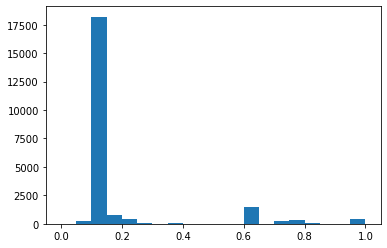

In [24]:
import matplotlib.pyplot as plt

train_proba = label_model.predict_proba(
    csr_matrix(convert_labels(train_L.todense(), "plusminus", "categorical"))
)
plt.hist(train_proba[:, 0], bins=20, range=(0.0, 1.0))
plt.show()

## Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use the noisy training labels we generated in the last tutorial part to train our end machine learning model.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!


## II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaliation.

In [25]:
from tf_model import get_features_and_labels, get_model

model = get_model()
tokens, idx1, idx2, label_probs = get_features_and_labels(
    train_df, train_proba, tf.float32
)
num_epochs = 1  # Change this to 10 when running.
model.fit((tokens, idx1, idx2), label_probs, steps_per_epoch=100, epochs=num_epochs)

W0723 02:54:59.623174 140192855889728 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0723 02:54:59.726130 140192855889728 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0723 02:54:59.983198 140192855889728 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0723 02:55:00.019353 140192855889728 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:36: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0723 02:55:00.073778 140192855889728 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0723 02:55:00.793532 140192855889728 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


  1/100 [..............................] - ETA: 1:09 - loss: 0.6914 - acc: 0.6406

  2/100 [..............................] - ETA: 42s - loss: 0.6634 - acc: 0.7422 

  3/100 [..............................] - ETA: 33s - loss: 0.6365 - acc: 0.7969

  4/100 [>.............................] - ETA: 29s - loss: 0.6148 - acc: 0.8281

  5/100 [>.............................] - ETA: 26s - loss: 0.6113 - acc: 0.8188

  6/100 [>.............................] - ETA: 24s - loss: 0.6034 - acc: 0.8177

  7/100 [=>............................] - ETA: 25s - loss: 0.5929 - acc: 0.8237

  8/100 [=>............................] - ETA: 25s - loss: 0.5850 - acc: 0.8242

  9/100 [=>............................] - ETA: 26s - loss: 0.5785 - acc: 0.8264

 10/100 [==>...........................] - ETA: 26s - loss: 0.5714 - acc: 0.8297

 11/100 [==>...........................] - ETA: 26s - loss: 0.5614 - acc: 0.8366

 12/100 [==>...........................] - ETA: 25s - loss: 0.5541 - acc: 0.8411

 13/100 [==>...........................] - ETA: 24s - loss: 0.5453 - acc: 0.8498

 14/100 [===>..........................] - ETA: 23s - loss: 0.5389 - acc: 0.8538

 15/100 [===>..........................] - ETA: 23s - loss: 0.5318 - acc: 0.8583

 16/100 [===>..........................] - ETA: 23s - loss: 0.5256 - acc: 0.8623

 17/100 [====>.........................] - ETA: 22s - loss: 0.5207 - acc: 0.8649

 18/100 [====>.........................] - ETA: 22s - loss: 0.5203 - acc: 0.8637

 19/100 [====>.........................] - ETA: 22s - loss: 0.5183 - acc: 0.8643

 20/100 [=====>........................] - ETA: 21s - loss: 0.5164 - acc: 0.8648

 21/100 [=====>........................] - ETA: 22s - loss: 0.5124 - acc: 0.8683

 22/100 [=====>........................] - ETA: 22s - loss: 0.5071 - acc: 0.8729

 23/100 [=====>........................] - ETA: 22s - loss: 0.5028 - acc: 0.8764

 24/100 [======>.......................] - ETA: 22s - loss: 0.4999 - acc: 0.8783

 25/100 [======>.......................] - ETA: 22s - loss: 0.4965 - acc: 0.8806

 26/100 [======>.......................] - ETA: 21s - loss: 0.4962 - acc: 0.8804

 27/100 [=======>......................] - ETA: 21s - loss: 0.4928 - acc: 0.8825

 28/100 [=======>......................] - ETA: 21s - loss: 0.4910 - acc: 0.8828

 29/100 [=======>......................] - ETA: 22s - loss: 0.4888 - acc: 0.8842

 30/100 [========>.....................] - ETA: 22s - loss: 0.4887 - acc: 0.8833

 31/100 [========>.....................] - ETA: 22s - loss: 0.4898 - acc: 0.8816

 32/100 [========>.....................] - ETA: 22s - loss: 0.4913 - acc: 0.8789

 33/100 [========>.....................] - ETA: 22s - loss: 0.4910 - acc: 0.8783

 34/100 [=========>....................] - ETA: 22s - loss: 0.4935 - acc: 0.8764

 35/100 [=========>....................] - ETA: 21s - loss: 0.4925 - acc: 0.8772

 36/100 [=========>....................] - ETA: 21s - loss: 0.4921 - acc: 0.8776

 37/100 [==========>...................] - ETA: 20s - loss: 0.4914 - acc: 0.8784

 38/100 [==========>...................] - ETA: 20s - loss: 0.4912 - acc: 0.8783

 39/100 [==========>...................] - ETA: 19s - loss: 0.4908 - acc: 0.8790

 40/100 [===========>..................] - ETA: 19s - loss: 0.4917 - acc: 0.8781

 41/100 [===========>..................] - ETA: 19s - loss: 0.4901 - acc: 0.8800

 42/100 [===========>..................] - ETA: 18s - loss: 0.4907 - acc: 0.8791

 43/100 [===========>..................] - ETA: 18s - loss: 0.4903 - acc: 0.8794

 44/100 [============>.................] - ETA: 17s - loss: 0.4906 - acc: 0.8789

 45/100 [============>.................] - ETA: 17s - loss: 0.4909 - acc: 0.8788

 46/100 [============>.................] - ETA: 16s - loss: 0.4907 - acc: 0.8787

 47/100 [=============>................] - ETA: 16s - loss: 0.4904 - acc: 0.8787

 48/100 [=============>................] - ETA: 15s - loss: 0.4891 - acc: 0.8799

 49/100 [=============>................] - ETA: 15s - loss: 0.4882 - acc: 0.8811

 50/100 [==============>...............] - ETA: 15s - loss: 0.4871 - acc: 0.8819

 51/100 [==============>...............] - ETA: 14s - loss: 0.4881 - acc: 0.8805

 52/100 [==============>...............] - ETA: 14s - loss: 0.4873 - acc: 0.8813

 53/100 [==============>...............] - ETA: 13s - loss: 0.4858 - acc: 0.8830

 54/100 [===============>..............] - ETA: 13s - loss: 0.4856 - acc: 0.8828

 55/100 [===============>..............] - ETA: 13s - loss: 0.4859 - acc: 0.8821

 56/100 [===============>..............] - ETA: 12s - loss: 0.4862 - acc: 0.8817

 57/100 [================>.............] - ETA: 12s - loss: 0.4856 - acc: 0.8819

 58/100 [================>.............] - ETA: 11s - loss: 0.4853 - acc: 0.8820

 59/100 [================>.............] - ETA: 11s - loss: 0.4856 - acc: 0.8816

 60/100 [=================>............] - ETA: 11s - loss: 0.4862 - acc: 0.8810

 61/100 [=================>............] - ETA: 10s - loss: 0.4854 - acc: 0.8817

 62/100 [=================>............] - ETA: 10s - loss: 0.4859 - acc: 0.8810

 63/100 [=================>............] - ETA: 10s - loss: 0.4854 - acc: 0.8817

 64/100 [==================>...........] - ETA: 9s - loss: 0.4867 - acc: 0.8804 

 65/100 [==================>...........] - ETA: 9s - loss: 0.4871 - acc: 0.8798

 66/100 [==================>...........] - ETA: 9s - loss: 0.4878 - acc: 0.8793

 67/100 [===================>..........] - ETA: 8s - loss: 0.4884 - acc: 0.8787

 68/100 [===================>..........] - ETA: 8s - loss: 0.4886 - acc: 0.8782

 69/100 [===================>..........] - ETA: 8s - loss: 0.4888 - acc: 0.8777

 70/100 [====================>.........] - ETA: 8s - loss: 0.4880 - acc: 0.8783

 71/100 [====================>.........] - ETA: 7s - loss: 0.4880 - acc: 0.8783

 72/100 [====================>.........] - ETA: 7s - loss: 0.4879 - acc: 0.8783

 73/100 [====================>.........] - ETA: 7s - loss: 0.4882 - acc: 0.8778

 74/100 [=====================>........] - ETA: 6s - loss: 0.4875 - acc: 0.8784

 75/100 [=====================>........] - ETA: 6s - loss: 0.4886 - acc: 0.8769

 76/100 [=====================>........] - ETA: 6s - loss: 0.4887 - acc: 0.8764

 77/100 [======================>.......] - ETA: 6s - loss: 0.4884 - acc: 0.8770

 78/100 [======================>.......] - ETA: 5s - loss: 0.4879 - acc: 0.8774

 79/100 [======================>.......] - ETA: 5s - loss: 0.4880 - acc: 0.8770

 80/100 [=======================>......] - ETA: 5s - loss: 0.4879 - acc: 0.8770

 81/100 [=======================>......] - ETA: 5s - loss: 0.4876 - acc: 0.8773

 82/100 [=======================>......] - ETA: 4s - loss: 0.4876 - acc: 0.8771

 83/100 [=======================>......] - ETA: 4s - loss: 0.4873 - acc: 0.8774

 84/100 [========================>.....] - ETA: 4s - loss: 0.4863 - acc: 0.8785

 85/100 [========================>.....] - ETA: 3s - loss: 0.4859 - acc: 0.8787

 86/100 [========================>.....] - ETA: 3s - loss: 0.4862 - acc: 0.8783

 87/100 [=========================>....] - ETA: 3s - loss: 0.4858 - acc: 0.8784

 88/100 [=========================>....] - ETA: 3s - loss: 0.4856 - acc: 0.8786

 89/100 [=========================>....] - ETA: 2s - loss: 0.4851 - acc: 0.8790

 90/100 [==========================>...] - ETA: 2s - loss: 0.4859 - acc: 0.8780

 91/100 [==========================>...] - ETA: 2s - loss: 0.4868 - acc: 0.8771

 92/100 [==========================>...] - ETA: 2s - loss: 0.4869 - acc: 0.8769

 93/100 [==========================>...] - ETA: 1s - loss: 0.4865 - acc: 0.8772

 94/100 [===========================>..] - ETA: 1s - loss: 0.4856 - acc: 0.8782

 95/100 [===========================>..] - ETA: 1s - loss: 0.4855 - acc: 0.8781

 96/100 [===========================>..] - ETA: 1s - loss: 0.4862 - acc: 0.8774

 97/100 [============================>.] - ETA: 0s - loss: 0.4856 - acc: 0.8781

 98/100 [============================>.] - ETA: 0s - loss: 0.4856 - acc: 0.8780

 99/100 [============================>.] - ETA: 0s - loss: 0.4853 - acc: 0.8783

100/100 [==============================] - 26s 259ms/step - loss: 0.4848 - acc: 0.8788


Finally, we can measure the trained model's prediction accuracy.

In [26]:
# Truncate sentences to limit memory usage when padding.
def pad_or_truncate(l, max_length=60):
    return l[:max_length] + [""] * (max_length - len(l))


test_tokens = np.array(list(map(pad_or_truncate, test_df.tokens)))
test_idx1 = np.array(list(map(list, test_df.person1_word_idx)))
test_idx2 = np.array(list(map(list, test_df.person2_word_idx)))
predictions = model.predict((test_tokens, test_idx1, test_idx2), steps=1)
mean_accuracy = (
    (predictions[:, 0] > 0.5) == (convert_labels(test_labels, "plusminus", "onezero"))
).mean()
print(f"Final Accuracy: {mean_accuracy}")

Final Accuracy: 0.9192891521658645
